# ITS_LIVE image-pairs

Access and point-sample [ITS_LIVE](https://its-live.jpl.nasa.gov/) image-pair velocity data from cloud-based Zarr datacubes

In [1]:
# EXPECTED RUNTIME: 50 sec

import geopandas as gpd
import xarray as xr

# Metadata for output Dataset
VAR_ATTRS = {
    "cd": {
        "description": "Centreline Distance: distance along glacier centre flowline from minimum observed terminus position",
        "units": "metres (positive=upstream)",
    },
    "glacier": {
        "description": "Glacier basin name from the Mouginot and others (2019) Greenland basins dataset",
    },
    "v": {
        "description": "median velocity magnitude sampled within a 1x1 km box about point (x,y)",
        "units": "metre/year",
    },
    "v_error": {
        "description": "median velocity magnitude error sampled within a 1x1 km box about point (x,y)",
        "units": "metre/year",
    },
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
}

# Variables to extract from datacubes
VARIABLES = [
    "v",
    "v_error",
    "date_dt",
    "mid_date",
    "mission_img1",
    "satellite_img1",
    "acquisition_date_img1",
    "acquisition_date_img2",
    "mapping",
]

# Read, sort, and select centreline points used for sampling
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier", "cd"])
points = points.loc[points.cd.isin([1_000, 5_000, 10_000, 20_000])].reset_index()

# Read ITS_LIVE datacube catalog and reproject to EPSG:3413
its_live_catalog_url = "https://its-live-data.s3-us-west-2.amazonaws.com/datacubes/catalog_v02.json"
its_live_catalog = gpd.read_file(its_live_catalog_url).to_crs(3413)

# Overlay points with datacube catalog to get intersecting datacube URLs (and modify to s3 format)
points = points.overlay(its_live_catalog[["geometry", "zarr_url"]], how="intersection")
points["zarr_url"] = points.zarr_url.str.replace("http:", "s3:")
points["zarr_url"] = points.zarr_url.str.replace(".s3.amazonaws.com", "")

# Container for sampled Datasets
velocity_ds = []

# Group centreline points by intersecting datacube
for zarr_url, points_cube in points.groupby(by="zarr_url"):
    # Open datacube
    itslive_ds = xr.open_dataset(zarr_url, engine="zarr", storage_options={"anon": True})

    # Group points by glacier
    for _, points_glacier in points_cube.groupby(by="glacier"):
        # Iterate over each point for current glacier
        for i, point in points_glacier.reset_index().iterrows():
            # Define slices for x and y bounds of 1km sampling box about point
            x = point.geometry.x
            y = point.geometry.y
            x_slice = slice(x - 500, x + 500)
            y_slice = slice(y + 500, y - 500)

            # Subset ITS_LIVE dataset by sampling box, selecting only variables of interest
            _velocity_ds = itslive_ds[VARIABLES].sel(x=x_slice, y=y_slice)

            # Lazily sample median v and v_error
            _velocity_ds["v"] = _velocity_ds.v.median(dim=["x", "y"]).assign_attrs(VAR_ATTRS["v"])
            _velocity_ds["v_error"] = _velocity_ds.v_error.median(dim=["x", "y"]).assign_attrs(VAR_ATTRS["v_error"])

            # Assign dimensions of current point as (glacier, cd)
            _velocity_ds = _velocity_ds.drop_dims(drop_dims=["x", "y"])
            _velocity_ds = _velocity_ds.expand_dims(dim=["glacier", "cd"])
            _velocity_ds = _velocity_ds.assign_coords(
                cd=("cd", [point.cd], VAR_ATTRS["cd"]),
                glacier=("glacier", [point.glacier], VAR_ATTRS["glacier"]),
                x=(("glacier", "cd"), [[point.geometry.x]], VAR_ATTRS["x"]),
                y=(("glacier", "cd"), [[point.geometry.y]], VAR_ATTRS["y"]),
            )
            velocity_ds.append(_velocity_ds)

# Concat sampled Datasets, sort by date, and write to disk
velocity_ds = xr.combine_nested(velocity_ds, concat_dim="mid_date", combine_attrs="drop_conflicts")
velocity_ds = velocity_ds.sortby("mid_date")
velocity_ds.to_netcdf("../data/velocity/velocity_subannual_1985_2022.nc")
velocity_ds

<xarray.Dataset> Size: 318MB
Dimensions:                (glacier: 2, cd: 4, mid_date: 696872)
Coordinates:
  * cd                     (cd) int32 16B 1000 5000 10000 20000
  * glacier                (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUN...
  * mid_date               (mid_date) datetime64[ns] 6MB 1984-11-23T13:26:21....
    x                      (glacier, cd) float64 64B 5.571e+05 ... 4.74e+05
    y                      (glacier, cd) float64 64B -1.896e+06 ... -2.437e+06
Data variables:
    v                      (glacier, cd, mid_date) float32 22MB nan ... 1.328...
    v_error                (glacier, cd, mid_date) float32 22MB nan nan ... 85.5
    date_dt                (glacier, cd, mid_date) timedelta64[ns] 45MB 400 d...
    mission_img1           (glacier, cd, mid_date) object 45MB 'L' nan ... 'S'
    satellite_img1         (glacier, cd, mid_date) object 45MB '5' nan ... '1A'
    acquisition_date_img1  (glacier, cd, mid_date) datetime64[ns] 45MB 1984-0...
    acquisition_date_img2  (glacier, cd, mid_date) datetime64[ns] 45MB 1985-0...
    mapping                (mid_date, glacier, cd) object 45MB '' nan ... nan ''
Attributes:
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    projection:                 3413
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities

Complete velocity time series at ~1 km upstream from the terminus (blue=DJ, orange=UI)

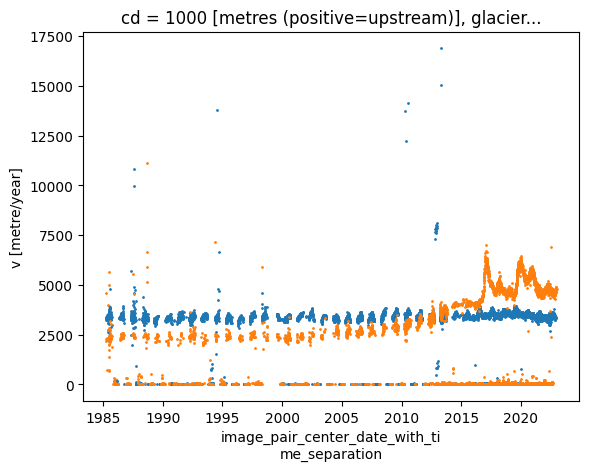

In [3]:
for _, ds in velocity_ds.sel(cd=1_000).groupby("glacier", squeeze=False):
    ds.v.dropna("mid_date").plot(linestyle="", marker="o", markersize=1)

Same as above, but preserving only short baseline (<= 30 day) granules

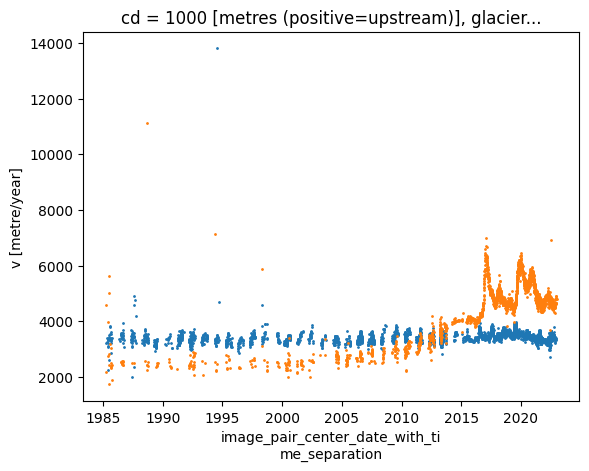

In [4]:
for _, ds in velocity_ds.sel(cd=1_000).groupby("glacier", squeeze=False):
    ds.where(ds.date_dt.dt.days <= 30, drop=True).v.dropna("mid_date").plot(linestyle="", marker="o", markersize=1)

Linear trend

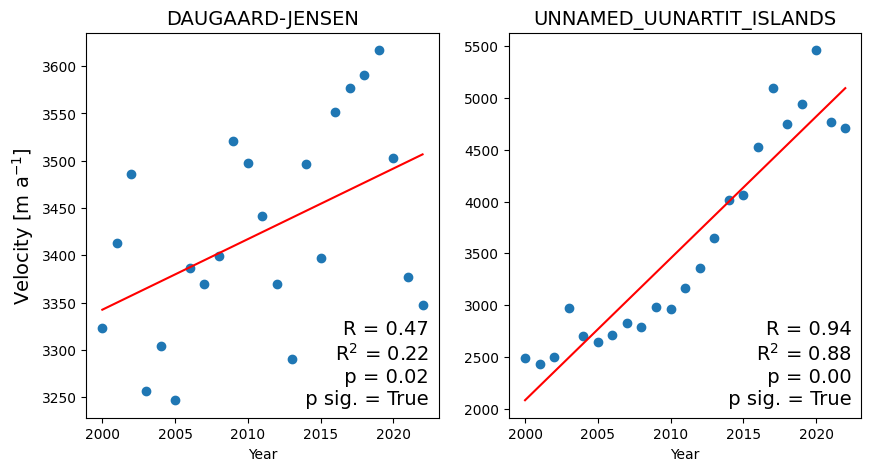

In [7]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

# Load discharge data
velocity_ds = xr.open_dataset("../data/velocity/velocity_subannual_1985_2022.nc")
velocity_ds = velocity_ds.sel(mid_date=slice("2000-01-01", "2024-01-01"))

for i, (glacier, ds) in enumerate(velocity_ds.groupby("glacier", squeeze=False)):
    ds = ds.sel(cd=1_000)
    ds = ds.where(ds.date_dt.dt.days <= 30, drop=True)
    velocity = ds.sortby("mid_date").v.resample(mid_date="1YS").mean().squeeze()
    years = velocity.mid_date.dt.year

    # Mask null values
    mask = velocity.notnull() & years.notnull()
    velocity = velocity.where(mask, drop=True)
    years = years.where(mask, drop=True)

    # Regress discharge against year
    res = scipy.stats.linregress(years, velocity)

    # Plot data and trendline
    axs[i].plot(years, velocity, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R = {res.rvalue:.2f}\n R$^{{2}}$ = {res.rvalue**2:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
            loc="lower right",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)
    axs[i].set_xlabel("Year")

axs[0].set_ylabel("Velocity [m a$^{-1}$]", size=14)

plt.show()

# ITS_LIVE mosaics

Illustrative access, sampling, and visualisation of ITS_LIVE mosaic data. These data can be downloaded using the below batch script (~35 GB) for quick subsequent analysis. Alternatively, these data can be streamed by uncommenting the indicated portion in the below Python cell -- this will increase run times to ~30 minutes.

Download [ITS_LIVE](https://its-live.jpl.nasa.gov/) annual velocity mosaics for 1985-2022

In [ ]:
!cd ../data/velocity/ & its_live-download.bat

Access and sample ITS_LIVE annual velocity mosaics along full glacier centrelines

In [8]:
# EXPECTED RUNTIME: 20 sec

import glob

import geopandas as gpd
import pandas as pd
import xarray as xr

# Metadata for output Dataset
VAR_ATTRS = {
    "cd": {
        "description": "Centreline Distance: distance along glacier centre flowline from minimum observed terminus position",
        "units": "metres (positive=upstream)",
    },
    "glacier": {
        "description": "Glacier basin name from the Mouginot and others (2019) Greenland basins dataset",
    },
    "v": {
        "description": "median velocity magnitude sampled within a 1x1 km box about point (x,y)",
        "units": "metre/year",
    },
    "v_error": {
        "description": "median velocity magnitude error sampled within a 1x1 km box about point (x,y)",
        "units": "metre/year",
    },
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
}


# Read, sort, and subset centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier", "cd"])
points = points.loc[points.cd.between(0, 20_000)].reset_index()

# Find file paths for all ITS_LIVE annual mosaics
files = glob.glob("../data/velocity/ITS_LIVE_velocity_120m_RGI05A_*_v02.nc")

# # OPTIONAL: Stream ITS_LIVE annual mosaics from S3 storage (avoids downloading ~35 GB)
# import s3fs
# its_live_s3 = s3fs.S3FileSystem(anon=True)
# its_live_s3_path = "s3://its-live-data/velocity_mosaic/v2/annual"
# files = its_live_s3.glob(f"{its_live_s3_path}/ITS_LIVE_velocity_120m_RGI05A_*_v02.nc")
# files = [its_live_s3.open(f, mode="rb") for f in files[1:]]

# Stack mosaics by year into lazy dask dataset
itslive_ds = xr.open_mfdataset(files, concat_dim="time", combine="nested")

# To store point-sampled subsets of its_live
velocity_ds = []

# Group points by glacier
for _, points_glacier in points.groupby(by="glacier"):
    # Iterate over each point for current glacier
    for _, point in points_glacier.reset_index().iterrows():
        # Define slices for x and y bounds of 1km sampling box about point
        x = point.geometry.x
        y = point.geometry.y
        x_slice = slice(x - 500, x + 500)
        y_slice = slice(y + 500, y - 500)

        # Subset ITS_LIVE dataset by sampling box
        _velocity_ds = itslive_ds.sel(x=x_slice, y=y_slice)

        # Sample median v and v_error (lazily)
        _velocity_ds["v"] = _velocity_ds.v.median(dim=["x", "y"]).assign_attrs(VAR_ATTRS["v"])
        _velocity_ds["v_error"] = _velocity_ds.v_error.median(dim=["x", "y"]).assign_attrs(VAR_ATTRS["v_error"])

        # Assign dimensions of current point as (glacier, cd), and
        # convert time dimension from index to datetime
        _velocity_ds = _velocity_ds.drop_dims(drop_dims=["x", "y"])
        _velocity_ds = _velocity_ds.expand_dims(dim=["glacier", "cd"])
        _velocity_ds = _velocity_ds.assign_coords(
            cd=("cd", [point.cd], VAR_ATTRS["cd"]),
            glacier=("glacier", [point.glacier], VAR_ATTRS["glacier"]),
            time=("time", [pd.to_datetime(i + 1985, format="%Y") for i in _velocity_ds.time.values]),
            x=(("glacier", "cd"), [[point.geometry.x]], VAR_ATTRS["x"]),
            y=(("glacier", "cd"), [[point.geometry.y]], VAR_ATTRS["y"]),
        )
        velocity_ds.append(_velocity_ds)

# Concat sampled Datasets and write to disk
velocity_ds = xr.combine_by_coords(velocity_ds, combine_attrs="drop_conflicts")
velocity_ds.to_netcdf("../data/velocity/velocity_annual_2000_2022.nc")
velocity_ds

<xarray.Dataset> Size: 77kB
Dimensions:  (glacier: 2, cd: 81, time: 38)
Coordinates:
  * cd       (cd) int32 324B 0 250 500 750 1000 ... 19250 19500 19750 20000
  * glacier  (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUNARTIT_ISLANDS'
  * time     (time) datetime64[ns] 304B 1985-01-01 1986-01-01 ... 2022-01-01
    x        (glacier, cd) float64 1kB 5.576e+05 5.575e+05 ... 4.74e+05
    y        (glacier, cd) float64 1kB -1.895e+06 -1.896e+06 ... -2.437e+06
Data variables:
    mapping  (glacier, cd, time) <U1 25kB '' '' '' '' '' '' ... '' '' '' '' ''
    v        (glacier, cd, time) float32 25kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    v_error  (glacier, cd, time) float32 25kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/14)
    author:                            ITS_LIVE, a NASA MEaSUREs project (its...
    datacube_autoRIFT_parameter_file:  http://its-live-data.s3.amazonaws.com/...
    institution:                       NASA Jet Propulsion Laboratory (JPL), ...
    region:                            RGI05A
    year:                              01-Jan-1985
    GDAL_AREA_OR_POINT:                Area
    ...                                ...
    title:                             ITS_LIVE annual mosaics of image pair ...
    date_created:                      15-Mar-2024 13:00:22
    latitude:                          [71.88]
    longitude:                         [-39.83]
    s3:                                s3://its-live-data/mosaics/annual/v2_s...
    url:                               http://its-live-data.s3.amazonaws.com/...

Annual velocity time series, plotted as for image-pair data above

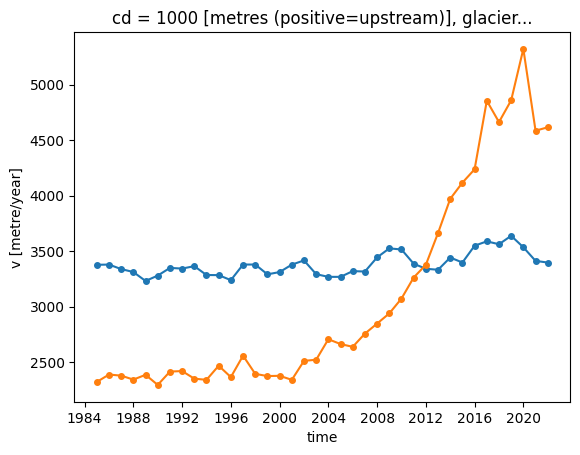

In [9]:
for _, ds in velocity_ds.sel(cd=1_000).groupby("glacier", squeeze=False):
    ds.v.plot(marker="o", markersize=4)

Along-flow velocity profile for 2020 (flow direction left to right)

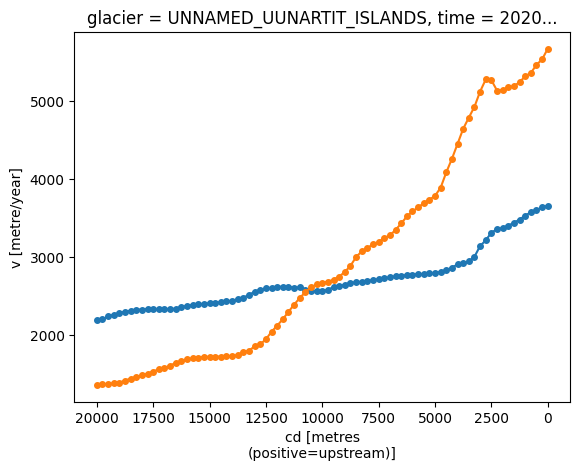

In [10]:
for _, ds in velocity_ds.sel(time="2020").groupby("glacier", squeeze=False):
    ds.v.plot(marker="o", markersize=4, xincrease=False)

Complete time series of velocity at Uunartit Islands

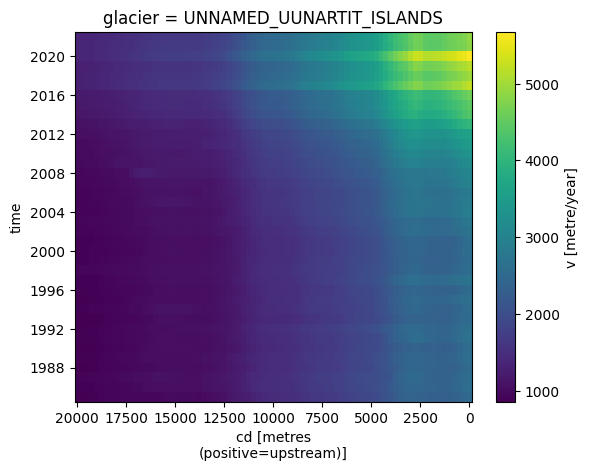

In [11]:
velocity_ds.sel(glacier="UNNAMED_UUNARTIT_ISLANDS").v.plot(x="cd", xincrease=False)